# iSNVs across the transmission bottleneck
# Nb estimates 
# TV/JT plots

**Date**: 2020-08-16, updated 2021-02-09  
**Author**: Katarina Braun 


## Overview
- This script will evaluate the iSNV frequencies across possible transmission pairs
- JT/TV plots will illustrate raw SNV frequency across each transmission event 
- Nb plot will employ the Sobel-Leonard/Koelle beta-binomial model to estimate the most likely size of each transmission bottleneck (Nb) 

Pleast note I am using the updated model as documented here: https://github.com/weissmanlab/BB_bottleneck

This module uses a 1% frequency cut-off. 


#### Generate files to go into the Koelle beta-binomial model to estimate transmission bottleneck sizes using SNP frequencies in index and donors 

syntax:  
index = donor  
contact = recipient 

**Notes from Katia Koelle regarding this model:**   
Assumptions about what SNPs are de novo vs transmitted make a huge difference. Since in our JVI paper we analyzed the contaminated Poon et al. data with a lot of within-host genetic diversity present, this didn't matter for our bottleneck estimates, but given that genetic diversity levels are actually really low within hosts, whether you assume an observed SNP is transmitted or arises de novo actually will make a big difference now.

1. If a SNP is observed at a frequency that indicates that it is likely fixed in a donor (i.e., that site is monomorphic in the donor), it shouldn't be included in the analysis, regardless of whether that site is polymorphic in the recipient.  


2. If a site is polymorphic in a donor (i.e., a SNP is present at a level that indicates that it is present but not fixed), it should be included in the analysis (regardless of whether the site is monomorphic or polymorphic in the recipient)  
    
    
    - A site being polymorphic (with a SNP being at high levels of ~50%) in the donor, and monomorphic in the recipient is an indication of a small bottleneck.  
    - A site being monomorphic in the donor, and polymorphic (especially at high SNP frequencies) in the recipient is also a strong indication of a small bottleneck. The more of these you see, the smaller the bottleneck likely is (assuming, that is, that you correctly identified a transmission pair)  
    
    
3. If your limit of detection is X, then any SNP below X or above 1-X should be considered fixed. (This is consistent with what McCrone does.) In my code, I assume that the input data for the donor consists ONLY of sites that are polymorphic (ie.. have SNPs that have values between X and 1-X), and the corresponding frequencies at those sites in the recipient. If the frequency at a given site in the recipient is below X or above 1-X, it shouldn't matter whether you set it to being fixed (i.e., set it to 0 or 1, respectively), or keep it at that observed value, of, for example, 0.005 or 0.995. Not 100% sure what Tyler Smith's R code assumes, so to be safe, you can set the frequencies at those recipient sites to 0 or 1 (depending on whether the SNP frequency is below X or above 1-X, respectively).  


4. Should I be including SNPs which are not present in the index but are present in the contact? --> No. These are very likely de novo variants. Their presence in your data indicate, however, that bottleneck sizes would be small.  


We assume that a SNP that is not observed in a recipient but present (but not fixed) in a donor can be either truly absent in the recipient, or present in the recipient only below the limit of detection.

**File that needs to be generated, input to beta-binomial model**:   
Column 1: frequency of SNP in index/donor  
Column 2: frequency of SNP in contact/recipient  
Column 3: total recipient reads --> I think this is "AD" in averaged VCF files  
Column 4: variant recipient reads --> I think this is "DP" in the average VCF files 

File type: `.txt`

Use 6 decimal positions for frequencies and read numbers.  
Separator = tab. 

Writing output files to this directory:     
`../beta_binomial/*`

Plug these files into this R script, located here:   
`./Bottleneck_size_estimation_exact.r`

syntax to run the exact model:   
```bash 
Rscript Bottleneck_size_estimation_exact.r --file pair2_beta-binomial-input.txt --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 5000 --confidence_level 0.99
```
** this script is easiest to run from the directory where the script and the input files are located

## Import modules and dependencies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
import seaborn as sns; sns.set()
from functools import reduce
import matplotlib as mpl
import pysam
import matplotlib.patches as mpatches

In [ ]:
# format samples as index dataframes

def index_dataframes(sample):
    index_r1 = pd.read_csv(filepath_or_buffer='../data_derived/vcfs-recode/' + sample + '_rep1.vcf', header=0, sep='\t', low_memory=False, skiprows=23)
    name = index_r1.columns[9]

    index_r1_2 = index_r1[['#CHROM', 'POS', 'REF', 'ALT']] #POS, REF, ALT
    index_r1_2['POS'] = index_r1_2['POS'].apply(str)
    index_r1_3 = index_r1[sample + '_rep1'].str.split(':', expand=True) #nothing here (just need this DF to expand column 26
    index_r1_5 = index_r1_3.rename(columns={6:'FREQ_index', 5:'variant_reads_index', 3:'total_reads_index'})
    pattern = '|'.join(['A_CALIFORNIA_04_2009','A_GUANGDONG_17SF003_2016','A_ANHUI_1_2013'])
    index_r1_2['gene'] = index_r1_2['#CHROM'].str.replace(pattern, '')
    index_r1_2['SNP'] = index_r1_2['gene'] + '-' + index_r1_2['POS'] + '-' + index_r1_2['REF'] + '>' + index_r1_2['ALT']
    index_r1 = pd.concat([index_r1_2, index_r1_5], axis=1, join='inner')
    index_r1['SNP'] = index_r1['SNP'].str.replace('_', '')
    index_r1 = index_r1[['SNP', 'POS', 'FREQ_index', 'total_reads_index', 'variant_reads_index']]
    index_r1['FREQ_index'].replace(regex=True, inplace=True, to_replace=r'%', value='')
    index_r1['FREQ_index'] = index_r1['FREQ_index'].apply(float) / 100

    index_r2 = pd.read_csv(filepath_or_buffer='../data_derived/vcfs-recode/' + sample + '_rep2.vcf', header=0, sep='\t', low_memory=False, skiprows=23)
    name = index_r2.columns[9]

    index_r2_2 = index_r2[['#CHROM', 'POS', 'REF', 'ALT']] #POS, REF, ALT
    index_r2_2['POS'] = index_r2_2['POS'].apply(str)
    index_r2_3 = index_r2[sample + '_rep2'].str.split(':', expand=True) #nothing here (just need this DF to expand column 26
    index_r2_5 = index_r2_3.rename(columns={6:'FREQ_index', 5:'variant_reads_index', 3:'total_reads_index'})
    pattern = '|'.join(['A_CALIFORNIA_04_2009','A_GUANGDONG_17SF003_2016','A_ANHUI_1_2013'])
    index_r2_2['gene'] = index_r2_2['#CHROM'].str.replace(pattern, '')
    index_r2_2['SNP'] = index_r2_2['gene'] + '-' + index_r2_2['POS'] + '-' + index_r2_2['REF'] + '>' + index_r2_2['ALT']
    index_r2 = pd.concat([index_r2_2, index_r2_5], axis=1, join='inner')
    index_r2['SNP'] = index_r2['SNP'].str.replace('_', '')
    index_r2 = index_r2[['SNP', 'POS', 'FREQ_index', 'total_reads_index', 'variant_reads_index']]
    index_r2['FREQ_index'].replace(regex=True, inplace=True, to_replace=r'%', value='')
    index_r2['FREQ_index'] = index_r2['FREQ_index'].apply(float) / 100

    index = pd.merge(index_r1, index_r2, how='outer', on='SNP')
    index = index.dropna()

    index['FREQ_index_x'] = index['FREQ_index_x'].astype(float).round(5)
    index['FREQ_index_y'] = index['FREQ_index_y'].astype(float).round(5)
    index['total_reads_index_x'] = index['total_reads_index_x'].astype(int)
    index['total_reads_index_y'] = index['total_reads_index_y'].astype(int)
    index['variant_reads_index_x'] = index['variant_reads_index_x'].astype(int)
    index['variant_reads_index_y'] = index['variant_reads_index_y'].astype(int)
    index['FREQ_index'] = index[['FREQ_index_x', 'FREQ_index_y']].mean(axis=1)
    index['total_reads_index'] = index[['total_reads_index_x', 'total_reads_index_y']].mean(axis=1)
    index['variant_reads_index'] = index[['variant_reads_index_x', 'variant_reads_index_y']].mean(axis=1)

    index = index[['SNP', 'POS_x', 'FREQ_index']]
    fixedrows = index[index['FREQ_index'] > 0.99].index
    index.drop(fixedrows, inplace=True)

    index = index.rename(columns={'POS_x':'POS'})

    return(index)

def index_loop(list_of_index_samples): 
    list_of_index_dfs = []
    for x in list_of_index_samples:
        y = index_dataframes(x)
        n = 'index_' + x
        y.name = n
        list_of_index_dfs.append(y)
    return(list_of_index_dfs)

In [ ]:
# format samples as contact dataframes

def contact_dataframes(sample):
    contact_r1 = pd.read_csv(filepath_or_buffer='../data_derived/vcfs-recode/' + sample + '_rep1.vcf', header=0, sep='\t', low_memory=False, skiprows=23)
    name = contact_r1.columns[9]

    contact_r1_2 = contact_r1[['#CHROM', 'POS', 'REF', 'ALT']] #POS, REF, ALT
    contact_r1_2['POS'] = contact_r1_2['POS'].apply(str)
    contact_r1_3 = contact_r1[sample + '_rep1'].str.split(':', expand=True) #nothing here (just need this DF to expand column 26
    contact_r1_5 = contact_r1_3.rename(columns={6:'FREQ_contact', 5:'variant_reads_contact', 3:'total_reads_contact'})
    pattern = '|'.join(['A_CALIFORNIA_04_2009','A_GUANGDONG_17SF003_2016','A_ANHUI_1_2013'])
    contact_r1_2['gene'] = contact_r1_2['#CHROM'].str.replace(pattern, '')
    contact_r1_2['SNP'] = contact_r1_2['gene'] + '-' + contact_r1_2['POS'] + '-' + contact_r1_2['REF'] + '>' + contact_r1_2['ALT']
    contact_r1 = pd.concat([contact_r1_2, contact_r1_5], axis=1, join='inner')
    contact_r1['SNP'] = contact_r1['SNP'].str.replace('_', '')
    contact_r1 = contact_r1[['SNP', 'POS', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]
    contact_r1['FREQ_contact'].replace(regex=True, inplace=True, to_replace=r'%', value='')
    contact_r1['FREQ_contact'] = contact_r1['FREQ_contact'].apply(float) / 100

    contact_r2 = pd.read_csv(filepath_or_buffer='../data_derived/vcfs-recode/' + sample + '_rep2.vcf', header=0, sep='\t', low_memory=False, skiprows=23)
    name = contact_r2.columns[9]

    contact_r2_2 = contact_r2[['#CHROM', 'POS', 'REF', 'ALT']] #POS, REF, ALT
    contact_r2_2['POS'] = contact_r2_2['POS'].apply(str)
    contact_r2_3 = contact_r2[sample + '_rep2'].str.split(':', expand=True) #nothing here (just need this DF to expand column 26
    contact_r2_5 = contact_r2_3.rename(columns={6:'FREQ_contact', 5:'variant_reads_contact', 3:'total_reads_contact'})
    pattern = '|'.join(['A_CALIFORNIA_04_2009','A_GUANGDONG_17SF003_2016','A_ANHUI_1_2013'])
    contact_r2_2['gene'] = contact_r2_2['#CHROM'].str.replace(pattern, '')
    contact_r2_2['SNP'] = contact_r2_2['gene'] + '-' + contact_r2_2['POS'] + '-' + contact_r2_2['REF'] + '>' + contact_r2_2['ALT']
    contact_r2 = pd.concat([contact_r2_2, contact_r2_5], axis=1, join='inner')
    contact_r2['SNP'] = contact_r2['SNP'].str.replace('_', '')
    contact_r2 = contact_r2[['SNP', 'POS', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]
    contact_r2['FREQ_contact'].replace(regex=True, inplace=True, to_replace=r'%', value='')
    contact_r2['FREQ_contact'] = contact_r2['FREQ_contact'].apply(float) / 100

    contact = pd.merge(contact_r1, contact_r2, how='outer', on='SNP')
    contact = contact.dropna()
    contact['FREQ_contact_x'] = contact['FREQ_contact_x'].astype(float).round(5)
    contact['FREQ_contact_y'] = contact['FREQ_contact_y'].astype(float).round(5)
    contact['total_reads_contact_x'] = contact['total_reads_contact_x'].astype(int)
    contact['total_reads_contact_y'] = contact['total_reads_contact_y'].astype(int)
    contact['variant_reads_contact_x'] = contact['variant_reads_contact_x'].astype(int)
    contact['variant_reads_contact_y'] = contact['variant_reads_contact_y'].astype(int)
    contact['FREQ_contact'] = contact[['FREQ_contact_x', 'FREQ_contact_y']].mean(axis=1)
    contact['total_reads_contact'] = contact[['total_reads_contact_x', 'total_reads_contact_y']].mean(axis=1)
    contact['variant_reads_contact'] = contact[['variant_reads_contact_x', 'variant_reads_contact_y']].mean(axis=1)

    contact = contact[['SNP', 'POS_x', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]

    contact = contact.rename(columns={'POS_x':'POS'})

    return(contact)

def contact_loop(list_of_contact_samples): 
    list_of_contact_dfs = []
    for x in list_of_contact_samples:
        y = contact_dataframes(x)
        n = 'contact_' + x
        y.name = n
        list_of_contact_dfs.append(y)
    return(list_of_contact_dfs)

In [ ]:
# index and contact are clearly defined in this case as ferret transmission pairs 
# there should be 1 Anhui, 1 GD3, 4 CA04, and 5 rGD3 transmission events (n=11 transmission events )

index = index_loop(['GD3_ferret3_day3','GD3_ferret4_day5','Anhui_ferret27_day1','Anhui_ferret28_day3','CA04_ferret1_day1','CA04_ferret2_day3','CA04_ferret3_day1','CA04_ferret4_day3','CA04_ferret5_day1','CA04_ferret6_day3','CA04_ferret35_day1','CA04_ferret36_day3','GD3_ferret9_day1','GD3_ferret10_day3','GD3_ferret11_day1','GD3_ferret12_day3','GD3_ferret15_day1','GD3_ferret16_day3','GD3_ferret17_day7','GD3_ferret18_day11','GD3_ferret21_day1','GD3_ferret22_day3'])
contact = contact_loop(['GD3_ferret3_day3','GD3_ferret4_day5','Anhui_ferret27_day1','Anhui_ferret28_day3','CA04_ferret1_day1','CA04_ferret2_day3','CA04_ferret3_day1','CA04_ferret4_day3','CA04_ferret5_day1','CA04_ferret6_day3','CA04_ferret35_day1','CA04_ferret36_day3','GD3_ferret9_day1','GD3_ferret10_day3','GD3_ferret11_day1','GD3_ferret12_day3','GD3_ferret15_day1','GD3_ferret16_day3','GD3_ferret17_day7','GD3_ferret18_day11','GD3_ferret21_day1','GD3_ferret22_day3'])

##

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [ ]:
# create a function to merge and index and contact dataframes for each comparison I'd like to make 

def merge(index, contact, pair): 
    BB = pd.merge(index, contact, how='outer', on=['SNP'])
    BB = BB.drop('POS_y', 1)
    BB = BB.rename(columns={'POS_x': 'POS'})
    BB = BB.dropna(subset=['POS'])
    BB = BB.replace(np.nan, 0)
#     print(BB)
    BB.to_csv('../data_derived/beta_binomial/' + 'pair_' + pair + '.csv', sep='\t')
    tolist = BB.loc[BB['total_reads_contact'] == 0]
    tolist = tolist.drop(['FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact'], axis=1)
    tolist[['gene', 'pos', 'nt_change']] = tolist['SNP'].str.split('-', expand=True)
    tolist = tolist.drop(['pos', 'nt_change'], axis=1)
    tolist = tolist.astype({'POS': int}) # convert POS column to integer dtype so getreaddepth function works below
#     print(tolist)
    contact_SNP = {k: g["POS"].tolist() for k,g in tolist.groupby("gene")}
#     print(tolist)
#     print(contact_SNP)
    return(tolist)


def merge_mod(index, contact, pair): 
    BB = pd.merge(index, contact, how='outer', on=['SNP'])
    BB = BB.drop('POS_y', 1)
    BB = BB.rename(columns={'POS_x': 'POS'})
    BB = BB.dropna(subset=['POS'])
    BB = BB.replace(np.nan, 0)
#     print(BB)
    BB.to_csv('../data_derived/beta_binomial/' + 'pair_' + pair + '.csv', sep='\t')


##

In [ ]:
# create a dictionary that I can use to pull out the correct dataframe from the list below 

sample_dict = {0:'GD3_ferret3_day3',1:'GD3_ferret4_day5',2:'Anhui_ferret27_day1',3:'Anhui_ferret28_day3',4:'CA04_ferret1_day1',5:'CA04_ferret2_day3',6:'CA04_ferret3_day1',7:'CA04_ferret4_day3',8:'CA04_ferret5_day1',9:'CA04_ferret6_day3',10:'CA04_ferret35_day1',11:'CA04_ferret36_day3',12:'GD3_ferret9_day1',13:'GD3_ferret10_day3',14:'GD3_ferret11_day1',15:'GD3_ferret12_day3',16:'GD3_ferret15_day1',17:'GD3_ferret16_day3',18:'GD3_ferret17_day7',19:'GD3_ferret18_day11',20:'GD3_ferret21_day1',21:'GD3_ferret22_day3'}


#

In [ ]:
# merge dataframes

tolist_1 = merge(index[0], contact[1], '1') 
tolist_2 = merge(index[2], contact[3], '2') 
tolist_3 = merge(index[4], contact[5], '3') 
tolist_4 = merge(index[6], contact[7], '4') 
tolist_5 = merge(index[8], contact[9], '5')
tolist_6 = merge(index[10], contact[11], '6') 
tolist_7 = merge(index[12], contact[13], '7') 
tolist_8 = merge(index[14], contact[15], '8') 
tolist_9 = merge_mod(index[16], contact[17], '9')
tolist_10 = merge(index[18], contact[19], '10') 
tolist_11 = merge_mod(index[20], contact[21], '11') 

#

In [ ]:
%%bash

## use samtools to index the bbmap bam that the modified zequencer generated

samtools index '../data_derived/bams/GD3_ferret3_day3_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret3_day3_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret4_day5_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret4_day5_rep2.bam'

samtools index '../data_derived/bams/Anhui_ferret27_day1_rep1.bam'
samtools index '../data_derived/bams/Anhui_ferret27_day1_rep2.bam'
samtools index '../data_derived/bams/Anhui_ferret28_day3_rep1.bam'
samtools index '../data_derived/bams/Anhui_ferret28_day3_rep2.bam'

samtools index '../data_derived/bams/CA04_ferret1_day1_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret1_day1_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret2_day3_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret2_day3_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret3_day1_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret3_day1_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret4_day3_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret4_day3_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret5_day1_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret5_day1_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret6_day3_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret6_day3_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret35_day1_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret35_day1_rep2.bam'
samtools index '../data_derived/bams/CA04_ferret36_day3_rep1.bam'
samtools index '../data_derived/bams/CA04_ferret36_day3_rep2.bam'

samtools index '../data_derived/bams/GD3_ferret9_day1_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret9_day1_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret10_day3_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret10_day3_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret11_day1_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret11_day1_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret12_day3_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret12_day3_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret15_day1_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret15_day1_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret16_day3_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret16_day3_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret17_day7_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret17_day7_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret18_day11_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret18_day11_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret21_day1_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret21_day1_rep2.bam'
samtools index '../data_derived/bams/GD3_ferret22_day3_rep1.bam'
samtools index '../data_derived/bams/GD3_ferret22_day3_rep2.bam'

#

In [ ]:
# this is function to get average read counts at each position 
def getReadDepth(bamfile, segment, pos):
    sam = pysam.AlignmentFile(bamfile, "rb")
    pileup = sam.pileup(contig=segment, start=pos-1, end=pos, truncate=True, stepper="nofilter")
    column = next(pileup)
    column.set_min_base_quality(30)
    return column.get_num_aligned()

In [ ]:
# apply the getReadDepth function to the dataframe DF_tolist slice, which contains

def RunGetReadDepth(pair_num_list, bam_num, ref):
    pair_num_list['total_reads_contact_1'] = pair_num_list.apply(lambda x:getReadDepth('../data_derived/bams/' + bam_num + '_rep1.bam', ref + '_' + x['gene'], x['POS']), axis=1)
    pair_num_list['total_reads_contact_2'] = pair_num_list.apply(lambda x:getReadDepth('../data_derived/bams/' + bam_num + '_rep2.bam', ref + '_' + x['gene'], x['POS']), axis=1)
    pair_num_list['total_reads_contact_1'] = pair_num_list['total_reads_contact_1'].astype(int)
    pair_num_list['total_reads_contact_2'] = pair_num_list['total_reads_contact_2'].astype(int)
    pair_num_list['total_reads_contact'] = pair_num_list[['total_reads_contact_1', 'total_reads_contact_2']].mean(axis=1)
    tolist = pair_num_list[['SNP', 'POS', 'gene', 'total_reads_contact']]
    return(tolist)

#   

In [ ]:
# run the above function, only needed for above non-empty lists
 
tolist_1 = RunGetReadDepth(tolist_1, 'GD3_ferret4_day5', 'A_GUANGDONG_17SF003_2016')
tolist_2 = RunGetReadDepth(tolist_2, 'Anhui_ferret28_day3', 'A_ANHUI_1_2013')
tolist_3 = RunGetReadDepth(tolist_3, 'CA04_ferret2_day3', 'A_CALIFORNIA_04_2009')
tolist_4 = RunGetReadDepth(tolist_4, 'CA04_ferret4_day3', 'A_CALIFORNIA_04_2009')
tolist_5 = RunGetReadDepth(tolist_5, 'CA04_ferret6_day3', 'A_CALIFORNIA_04_2009')
tolist_6 = RunGetReadDepth(tolist_6, 'CA04_ferret36_day3', 'A_CALIFORNIA_04_2009')
tolist_7 = RunGetReadDepth(tolist_7, 'GD3_ferret10_day3', 'A_GUANGDONG_17SF003_2016')
tolist_8 = RunGetReadDepth(tolist_8, 'GD3_ferret12_day3', 'A_GUANGDONG_17SF003_2016')
tolist_10 = RunGetReadDepth(tolist_10, 'GD3_ferret18_day11', 'A_GUANGDONG_17SF003_2016')

#

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
def updateBBdataframe(df_list, pair_num): 
    df_BB = pd.read_csv('../data_derived/beta_binomial/' + pair_num + '.csv', sep='\t')
    contactDP = df_list.drop(['gene', 'POS'], axis=1)
    df_final = contactDP.combine_first(df_BB).reindex(df_BB.index)
    DF_final = df_final[['SNP', 'FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]
    DF_final = DF_final[DF_final.FREQ_index != 0]
    DF_final.to_csv('../data_derived/beta_binomial/' + pair_num + '.csv', sep='\t')
    DF_final_noSNPs = DF_final.drop(['SNP'], axis=1)
    DF_final_noSNPs['FREQ_contact'] = np.where(DF_final_noSNPs['FREQ_contact']>=0.99, 0.999999, DF_final_noSNPs['FREQ_contact'])
    DF_final_noSNPs = DF_final_noSNPs.astype(str)
    DF_final_noSNPs = DF_final_noSNPs.astype(float).round(6)
    DF_final_noSNPs.to_csv('../data_derived/beta_binomial/' + pair_num + '_beta-binomial-input.txt', sep='\t', header=None, index=False, float_format='%.6f')
    return(DF_final_noSNPs)

def updateBBdataframe_mod(pair_num): 
    df_BB = pd.read_csv('../data_derived/beta_binomial/' + pair_num + '.csv', sep='\t')
#     print(df_BB)
    DF_final = df_BB[['SNP', 'FREQ_index', 'FREQ_contact', 'total_reads_contact', 'variant_reads_contact']]
    DF_final.to_csv('../data_derived/beta_binomial/' + pair_num + '.csv', sep='\t')
    DF_final_noSNPs = DF_final.drop(['SNP'], axis=1)
    DF_final_noSNPs['FREQ_contact'] = np.where(DF_final_noSNPs['FREQ_contact']>=0.99, 0.999999, DF_final_noSNPs['FREQ_contact'])
    DF_final_noSNPs = DF_final_noSNPs.astype(str)
    DF_final_noSNPs = DF_final_noSNPs.astype(float).round(6)
    DF_final_noSNPs.to_csv('../data_derived/beta_binomial/' + pair_num + '_beta-binomial-input.txt', sep='\t', header=None, index=False, float_format='%.6f')
    return(DF_final_noSNPs)

In [ ]:
# run the above dataframes

pair1_final = updateBBdataframe(tolist_1, 'pair_1')
pair2_final = updateBBdataframe(tolist_2, 'pair_2')
pair3_final = updateBBdataframe(tolist_3, 'pair_3')
pair4_final = updateBBdataframe(tolist_4, 'pair_4')
pair5_final = updateBBdataframe(tolist_5, 'pair_5')
pair6_final = updateBBdataframe(tolist_6, 'pair_6')
pair7_final = updateBBdataframe(tolist_7, 'pair_7')
pair8_final = updateBBdataframe(tolist_8, 'pair_8')
pair9_final = updateBBdataframe_mod('pair_9')
pair10_final = updateBBdataframe(tolist_10, 'pair_10')
pair11_final = updateBBdataframe_mod('pair_11')

#

In [ ]:
%%bash 

Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_1_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_1_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_2_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_2_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_3_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_3_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_4_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_4_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_5_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_5_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_6_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_6_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_7_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_7_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_8_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_8_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_9_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_9_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_10_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_10_output.txt'
Rscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_11_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_11_output.txt'

##

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'rmutil':
  method         from
  print.response httr

Attaching package: ‘rmutil’

The following object is masked from ‘package:tidyr’:

    nesting

The following object is masked from ‘package:stats’:

    nobs

The following objects are masked from ‘package:base’:

    as.data.frame, units

There were 50 or more warnings (us

CalledProcessError: Command 'b"\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_1_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_1_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_2_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_2_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_3_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_3_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_4_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_4_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_5_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_5_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_6_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_6_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_7_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_7_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_8_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_8_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_9_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_9_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_10_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_10_output.txt'\nRscript Bottleneck_size_estimation_exact.r --file '../data_derived/beta_binomial/pair_11_beta-binomial-input.txt' --plot_bool TRUE --var_calling_threshold 0.01 --Nb_min 1 --Nb_max 100 --confidence_level 0.95 > '../data_derived/beta_binomial/pair_11_output.txt'\n\n##\n"' returned non-zero exit status 1.

No handles with labels found to put in legend.
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


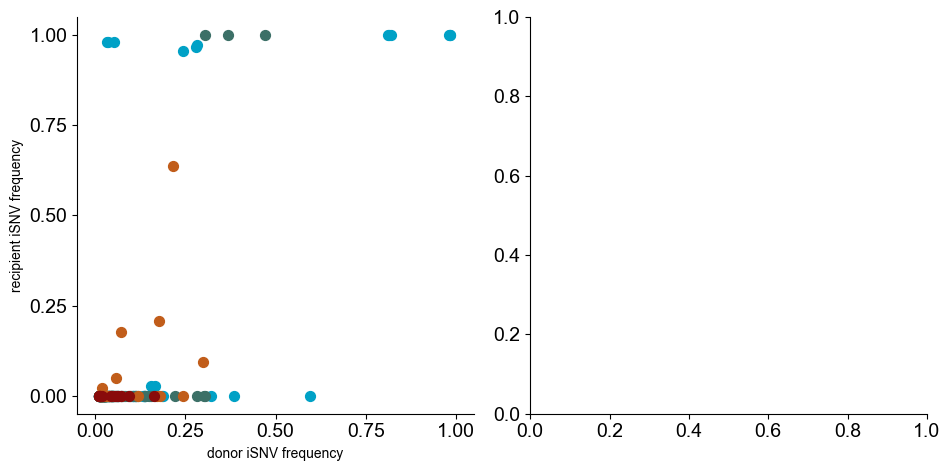

In [ ]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1,3)

# ax1 = fig.add_subplot(gs[0,0:4], aspect='equal') # JT/TV plot
ax1 = fig.add_subplot(gs[0,0:1], aspect='equal') # JT/TV plot - ZOOM
ax3 = fig.add_subplot(gs[0,1:2], aspect='equal') # JT/TV plot - ZOOM

# get right of top and right frame of each subplot
axes = (ax1, ax3)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize=12 of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax1.tick_params(axis = 'both', which = 'minor', labelsize = 14)

ax3.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 14)

#FOR PLOT 4B
ax1.scatter(pair1_final.FREQ_index, pair1_final.FREQ_contact, s=50, marker='o', facecolor='#00A1C6', edgecolor='#00A1C6')
ax1.scatter(pair2_final.FREQ_index, pair2_final.FREQ_contact, s=50, marker='o', facecolor='#3C7067', edgecolor='#3C7067')
ax1.scatter(pair3_final.FREQ_index, pair3_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax1.scatter(pair4_final.FREQ_index, pair4_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax1.scatter(pair5_final.FREQ_index, pair5_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax1.scatter(pair6_final.FREQ_index, pair6_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax1.scatter(pair7_final.FREQ_index, pair7_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax1.scatter(pair8_final.FREQ_index, pair8_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax1.scatter(pair9_final.FREQ_index, pair9_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax1.scatter(pair10_final.FREQ_index, pair10_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax1.scatter(pair11_final.FREQ_index, pair11_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')

# edit the axes - ax1
ax1.set_title('', fontname='Arial', fontsize=14)
ax1.set_ylabel('recipient iSNV frequency', fontname='Arial', fontsize=10)
ax1.set_xlabel('donor iSNV frequency', fontname='Arial', fontsize=10)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(-0.05,1.05)
ax1.set_yticks([0,0.25,0.5,0.75,1.0])
ax1.set_xlim(-0.05,1.05)
ax1.set_xticks([0,0.25,0.5,0.75,1.0])

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
plt.legend(frameon=False, ncol=3, bbox_to_anchor=(1,1)) 
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/TV-plots/combined_pairs.pdf", bbox_inches='tight', dpi=300)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


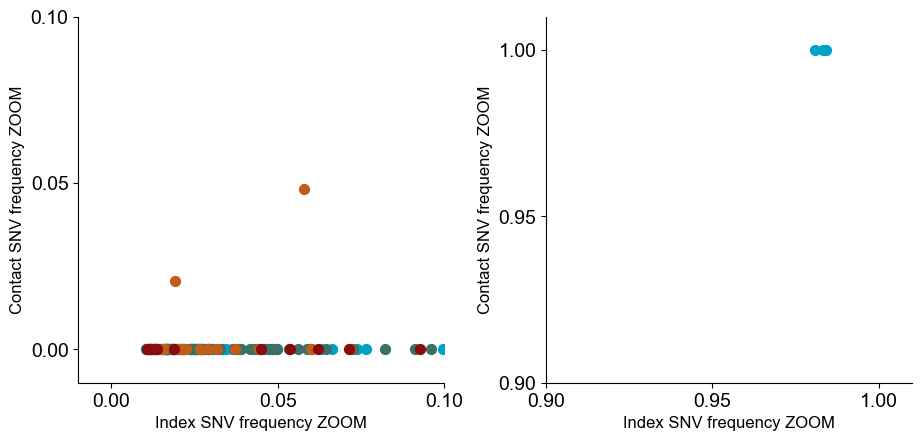

In [ ]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(1,3)

# ax1 = fig.add_subplot(gs[0,0:4], aspect='equal') # JT/TV plot
ax2 = fig.add_subplot(gs[0,0:1], aspect='equal') # JT/TV plot - ZOOM
ax3 = fig.add_subplot(gs[0,1:2], aspect='equal') # JT/TV plot - ZOOM

# get right of top and right frame of each subplot
axes = (ax2, ax3)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize=12 of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax2.tick_params(axis = 'both', which = 'minor', labelsize = 14)

ax3.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 14)
    
#FOR PLOT 4B
ax2.scatter(pair1_final.FREQ_index, pair1_final.FREQ_contact, s=50, marker='o', facecolor='#00A1C6', edgecolor='#00A1C6')
ax2.scatter(pair2_final.FREQ_index, pair2_final.FREQ_contact, s=50, marker='o', facecolor='#3C7067', edgecolor='#3C7067')
ax2.scatter(pair3_final.FREQ_index, pair3_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax2.scatter(pair4_final.FREQ_index, pair4_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax2.scatter(pair5_final.FREQ_index, pair5_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax2.scatter(pair6_final.FREQ_index, pair6_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax2.scatter(pair7_final.FREQ_index, pair7_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax2.scatter(pair8_final.FREQ_index, pair8_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax2.scatter(pair9_final.FREQ_index, pair9_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax2.scatter(pair10_final.FREQ_index, pair10_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax2.scatter(pair11_final.FREQ_index, pair11_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')

# edit the axes - ax2
ax2.set_title('', fontname='Arial', fontsize=14)
ax2.set_ylabel('Contact SNV frequency ZOOM', fontname='Arial', fontsize=12)
ax2.set_xlabel('Index SNV frequency ZOOM', fontname='Arial', fontsize=12)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(-0.01, 0.1)
ax2.set_yticks([0, 0.05, 0.1])
ax2.set_xlim(-0.01, 0.1)
ax2.set_xticks([0, 0.05, 0.1])

#FOR PLOT 4B
ax3.scatter(pair1_final.FREQ_index, pair1_final.FREQ_contact, s=50, marker='o', facecolor='#00A1C6', edgecolor='#00A1C6')
ax3.scatter(pair2_final.FREQ_index, pair2_final.FREQ_contact, s=50, marker='o', facecolor='#3C7067', edgecolor='#3C7067')
ax3.scatter(pair3_final.FREQ_index, pair3_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax3.scatter(pair4_final.FREQ_index, pair4_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax3.scatter(pair5_final.FREQ_index, pair5_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax3.scatter(pair6_final.FREQ_index, pair6_final.FREQ_contact, s=50, marker='o', facecolor='#C15D1A', edgecolor='#C15D1A')
ax3.scatter(pair7_final.FREQ_index, pair7_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax3.scatter(pair8_final.FREQ_index, pair8_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax3.scatter(pair9_final.FREQ_index, pair9_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax3.scatter(pair10_final.FREQ_index, pair10_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')
ax3.scatter(pair11_final.FREQ_index, pair11_final.FREQ_contact, s=50, marker='o', facecolor='#890B0B', edgecolor='#890B0B')

plt.legend()
    
# edit the axes - ax3
ax3.set_title('', fontname='Arial', fontsize=1214)
ax3.set_ylabel('Contact SNV frequency ZOOM', fontname='Arial', fontsize=12)
ax3.set_xlabel('Index SNV frequency ZOOM', fontname='Arial', fontsize=12)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
ax3.set_ylim(0.9, 1.01)
ax3.set_yticks([0.9, 0.95, 1.0])
ax3.set_xlim(0.9, 1.01)
ax3.set_xticks([0.9, 0.95, 1.0])

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(1,1), fontsize=14) 
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/TV-plots/combined-pairs-with-zoom.pdf", bbox_inches='tight', dpi=300)

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


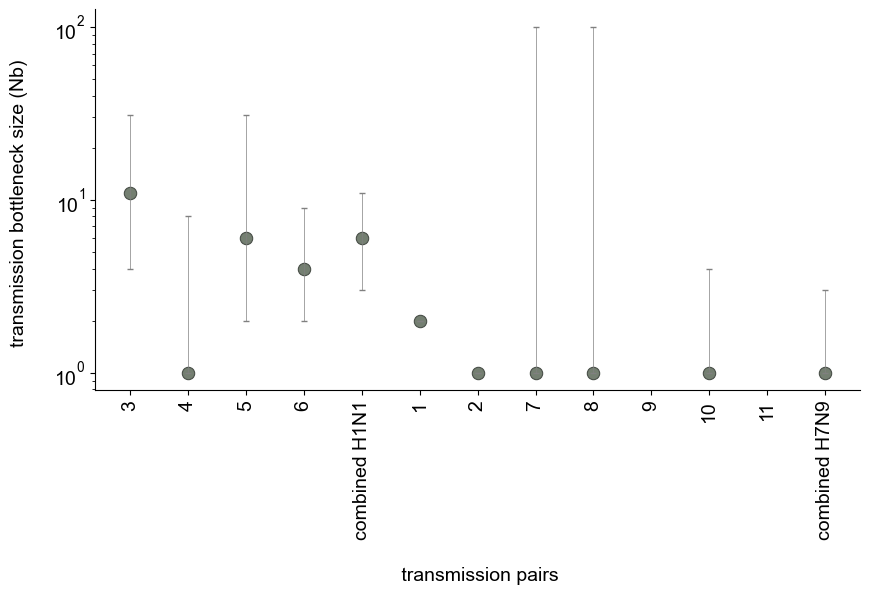

In [ ]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(14,10), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 10)

ax3 = fig.add_subplot(gs[0,0:6]) # beta-binomial estimates 

# get right of top and right frame of each subplot
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax3.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax3.tick_params(axis = 'both', which = 'minor', labelsize = 14)

# FOR PLOT 4C 
# these values for the bottleneck size (Nb) as well as left and right confidence intervals 
# are pulled from the cells above, which document the output from the exact beta-binomial model
BB = pd.DataFrame({"":['3','4','5','6','combined H1N1','1','2','7','8','9','10','11','combined H7N9'],
                   "Nb":[11,1,6,4,6,2,1,1,1,0,1,0,1], 
                   "CI-left":[4,1,2,2,3,2,1,1,1,0,1,0,1], 
                   "CI-right":[31,8,31,9,11,2,1,100,100,0,4,0,3]})

BB_pair3 = BB.loc[[0]]
BB_pair4 = BB.loc[[1]]
BB_pair5 = BB.loc[[2]]
BB_pair6 = BB.loc[[3]]
BB_combinedH1N1 = BB.loc[[4]]

BB_pair1 = BB.loc[[5]]
BB_pair2 = BB.loc[[6]]
BB_pair7 = BB.loc[[7]]
BB_pair8 = BB.loc[[8]]
BB_pair9 = BB.loc[[9]]
BB_pair10 = BB.loc[[10]]
BB_pair11 = BB.loc[[11]]
BB_combinedH7N9 = BB.loc[[12]]


yerr_pair1 = [BB_pair1['Nb'] - BB_pair1['CI-left'], BB_pair1['CI-right'] - BB_pair1['Nb']]
yerr_pair2 = [BB_pair2['Nb'] - BB_pair2['CI-left'], BB_pair2['CI-right'] - BB_pair2['Nb']]
yerr_pair3 = [BB_pair3['Nb'] - BB_pair3['CI-left'], BB_pair3['CI-right'] - BB_pair3['Nb']]
yerr_pair4 = [BB_pair4['Nb'] - BB_pair4['CI-left'], BB_pair4['CI-right'] - BB_pair4['Nb']]
yerr_pair5 = [BB_pair5['Nb'] - BB_pair5['CI-left'], BB_pair5['CI-right'] - BB_pair5['Nb']]
yerr_pair6 = [BB_pair6['Nb'] - BB_pair6['CI-left'], BB_pair6['CI-right'] - BB_pair6['Nb']]
yerr_pair7 = [BB_pair7['Nb'] - BB_pair7['CI-left'], BB_pair7['CI-right'] - BB_pair7['Nb']]
yerr_pair8 = [BB_pair8['Nb'] - BB_pair8['CI-left'], BB_pair8['CI-right'] - BB_pair8['Nb']]
yerr_pair9 = [BB_pair9['Nb'] - BB_pair9['CI-left'], BB_pair9['CI-right'] - BB_pair9['Nb']]
yerr_pair10 = [BB_pair10['Nb'] - BB_pair10['CI-left'], BB_pair10['CI-right'] - BB_pair10['Nb']]
yerr_pair11 = [BB_pair11['Nb'] - BB_pair11['CI-left'], BB_pair11['CI-right'] - BB_pair11['Nb']]
yerr_combinedH1N1 = [BB_combinedH1N1['Nb'] - BB_combinedH1N1['CI-left'], BB_combinedH1N1['CI-right'] - BB_combinedH1N1['Nb']]
yerr_combinedH7N9 = [BB_combinedH7N9['Nb'] - BB_combinedH7N9['CI-left'], BB_combinedH7N9['CI-right'] - BB_combinedH7N9['Nb']]

# axes
ax3 = sns.scatterplot('', 'Nb', data=BB, ci=None, s=80, marker='o', facecolor='#747F71', edgecolor='#444A43')
ax3.set_ylabel('Transmission bottleneck size (Nb)', fontname='Arial', fontsize=14)
ax3.errorbar(x=BB_pair1[''], y=BB_pair1['Nb'], yerr=yerr_pair1, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair2[''], y=BB_pair2['Nb'], yerr=yerr_pair2, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair3[''], y=BB_pair3['Nb'], yerr=yerr_pair3, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair4[''], y=BB_pair4['Nb'], yerr=yerr_pair4, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair5[''], y=BB_pair5['Nb'], yerr=yerr_pair5, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair6[''], y=BB_pair6['Nb'], yerr=yerr_pair6, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair7[''], y=BB_pair7['Nb'], yerr=yerr_pair7, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair8[''], y=BB_pair8['Nb'], yerr=yerr_pair8, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair9[''], y=BB_pair9['Nb'], yerr=yerr_pair9, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair10[''], y=BB_pair10['Nb'], yerr=yerr_pair10, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_pair11[''], y=BB_pair11['Nb'], yerr=yerr_pair11, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_combinedH1N1[''], y=BB_combinedH1N1['Nb'], yerr=yerr_combinedH1N1, fmt='grey', capsize=2, elinewidth=0.5)
ax3.errorbar(x=BB_combinedH7N9[''], y=BB_combinedH7N9['Nb'], yerr=yerr_combinedH7N9, fmt='grey', capsize=2, elinewidth=0.5)

# edit the axes - ax3
ax3.set_title('', fontname='Arial', fontsize=14)
ax3.set_ylabel('transmission bottleneck size (Nb) \n', fontname='Arial', fontsize=14)
ax3.set_xlabel('\n transmission pairs', fontname='Arial', fontsize=14)
ax3.set_facecolor('white')
for tick in ax3.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax3.get_yticklabels():
    tick.set_fontname("Arial")
plt.xticks(rotation=90)
ax3.set_yscale('log')

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/bottlenecks/beta-binomial-estimates-all.pdf", bbox_inches='tight', dpi=300)


In [ ]:
from scipy.stats import ttest_ind

ttest_ind([11,1,6,4],[2,1,1,1,1])

Ttest_indResult(statistic=2.3121716976731768, pvalue=0.0540137120041597)